In [38]:
import os
print(os.listdir("../input"))
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.metrics import confusion_matrix
from sklearn import metrics

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm as tn

import random
import spacy
import re

# from sklearn.decomposition import TruncatedSVD
# from scipy.sparse import csr_matrix
from yellowbrick.text import TSNEVisualizer
# from yellowbrick.text.tsne import tsne


['twitter-entity-sentiment-analysis']


In [2]:
train_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv'
valid_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'
cols = ['Id', 'Entity', 'Sentiment', 'Tweet']
train = pd.read_csv(train_path, names = cols, header=None)
valid = pd.read_csv(valid_path, names = cols)
# train['is_train'], valid['is_train'] = True, False
all_df = train.append(valid)
all_df.index = range(len(pd.RangeIndex(len(all_df.index))))
all_df

,Id,Entity,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
75677,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75678,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75679,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
75680,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [3]:
labeled_df = train[['Sentiment', 'Tweet']].copy()
labeled_df['label'] = labeled_df.Sentiment.factorize()[0]#0-pos,1-neutr,2-neg
labeled_df['label'] = [int(1) if i==3 else i for i in labeled_df.label.tolist()]
labeled_df = labeled_df.drop(columns='Sentiment').drop_duplicates().dropna()
labeled_df.label.value_counts()

1    29320
2    21237
0    19138
Name: label, dtype: int64

In [4]:
labeled_valid = valid[['Sentiment', 'Tweet']].copy()
labeled_valid['label'] = labeled_valid.Sentiment.factorize()[0]#0-pos,1-neutr,2-neg
labeled_valid['label'] = [int(1) if i==3 else i for i in labeled_valid.label.tolist()]
labeled_valid = labeled_valid.drop(columns='Sentiment').drop_duplicates().dropna()
labeled_valid.label.value_counts()

1    561
2    266
0    172
Name: label, dtype: int64

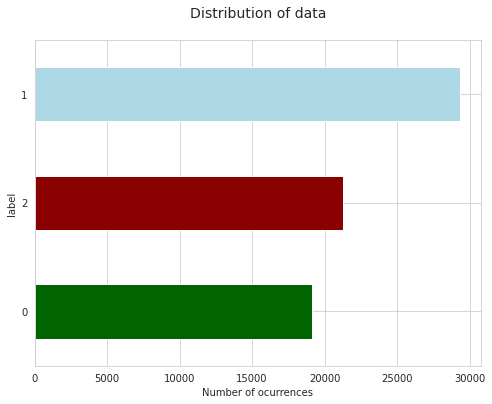

In [5]:
fig = plt.figure(figsize=(8,6))
colors = ['darkgreen', 'darkred', 'lightblue']#0-pos,1-neutr,2-neg
labeled_df.groupby(['label']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Distribution of data\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [54]:
pos = labeled_df[labeled_df['label']==0].sample(19000, random_state=1).copy()
neg = labeled_df[labeled_df['label']==2].sample(19000, random_state=1).copy()
neu = labeled_df[labeled_df['label']==1].sample(19000, random_state=1).copy()
balanced_df = pos.append(neg).append(neu).reset_index(drop=True)
balanced_df

,Tweet,label
0,"It was another true epic, omfg",0
1,honestly about this point... will top for a ps...,0
2,Finally we got our hands on Borderlands 3 at @...,0
3,FUCK YESSSSSSSS .,0
4,"But I won't lie, I follow A LOT of NBA 2K cont...",0
...,...,...
56995,"Unfortunately, Vlad lost the series... Thanks ...",1
56996,Your Hell behaves suspiciously?.,1
56997,The Overwatch team I'm with won our game 3-0 a...,1
56998,Jack @bibanator has scammed me out of all thre...,1


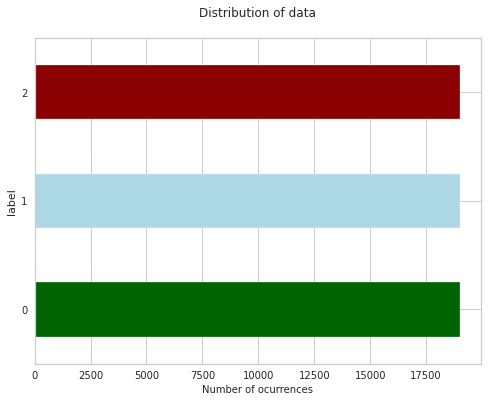

In [73]:
fig = plt.figure(figsize=(8,6))
colors = ['darkgreen','lightblue', 'darkred']#0-pos,1-neutr,2-neg
balanced_df.groupby(['label']).Tweet.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'Distribution of data\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

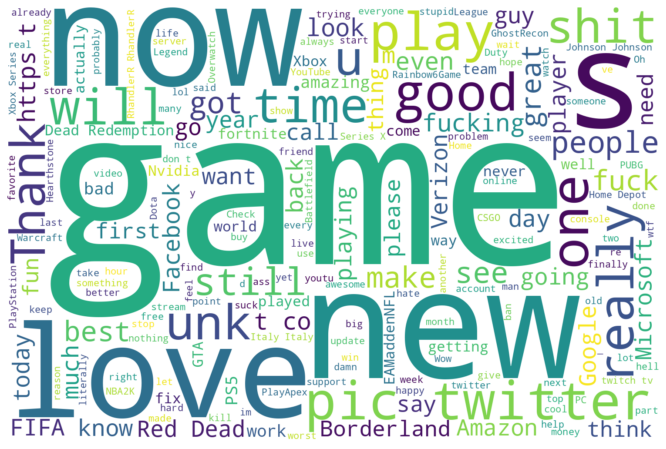

In [21]:
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(' '.join(balanced_df['Tweet']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

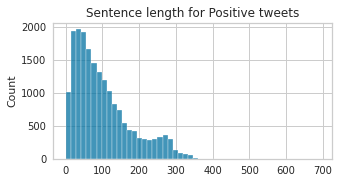

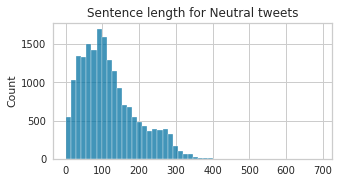

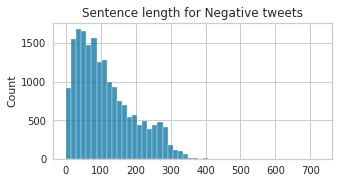

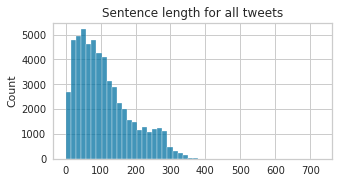

In [80]:
for i,j in enumerate(['Positive','Neutral','Negative', 'all']):
    plt.figure(figsize=(5, 2.5))
    if i<3: sns.histplot([len(s) for s in balanced_df[balanced_df['label']==i]['Tweet']], bins=50)
    else: sns.histplot([len(s) for s in balanced_df['Tweet']], bins=50)
    plt.title('Sentence length for '+ j + ' tweets')
    plt.show()

In [93]:
for i,j in enumerate(['Positive','Neutral','Negative', 'All']):
    if i<3: print(j + ' mean sentence length: '+ str(pd.Series([len(s) for s in balanced_df[balanced_df['label']==i]['Tweet']]).mean()))
    else: print(j + ' mean sentence length: '+ str(pd.Series([len(s) for s in balanced_df['Tweet']]).mean()))

print()

for i,j in enumerate(['Positive','Neutral','Negative', 'All']):
    if i<3: print(j + ' median sentence length: '+ str(pd.Series([len(s) for s in balanced_df[balanced_df['label']==i]['Tweet']]).median()))
    else: print(j + ' median sentence length: '+ str(pd.Series([len(s) for s in balanced_df['Tweet']]).median()))


Positive mean sentence length: 100.53242105263158
Neutral mean sentence length: 118.54978947368421
Negative mean sentence length: 114.95026315789474
All mean sentence length: 111.34415789473684

Positive median sentence length: 80.0
Neutral median sentence length: 103.0
Negative median sentence length: 95.0
All median sentence length: 93.0


## Sentiment Analysis using Transformers

More research on Sentiment Analysis with Transformers could be found in this [article](https://www.analyticsvidhya.com/blog/2022/02/sentiment-analysis-using-transformers/)

In [9]:
!pip install -U transformers

     |████████████████████████████████| 4.2 MB 929 kB/s            
     |████████████████████████████████| 6.6 MB 48.1 MB/s            
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.15.0
    Uninstalling transformers-4.15.0:
      Successfully uninstalled transformers-4.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.0 requires transformers<4.16,>=4.1, but you have transformers 4.19.2 which is incompatible.


In [10]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [56]:
labels = balanced_df['label'].tolist()
tweets = balanced_df['Tweet'].tolist()

[DistilBertTokenizerFast](https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/distilbert#transformers.DistilBertTokenizerFast) is identical to `BertTokenizerFast` and runs end-to-end tokenization: punctuation splitting and wordpiece.

In [12]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [57]:
inputs = tokenizer(tweets, padding='max_length', truncation = True)

Class for converting the data into tensors (since we are using PyTorch)

In [14]:
class twDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self,idx):
        item = {key:torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

`Input id’s`: This contains tensors of integers where each integer represents the word from the original sentence.

`Attention Mask`: It is simply an array of 1’s and 0’s indicating which tokens are padding and which aren’t.

`Labels`: target variables

In [58]:
tr_df = twDataset(inputs, labels)
tr_df.__getitem__(2000)

{'input_ids': tensor([  101,  2204,  2851,   999,  2009,  2001,  2061,  2980,  1998,  5931,
          2197,  2305,  2008,  1045,  3092,  2039,  4815,  2041,  2035,  2305,
          1010,  2272,  2000,  2033,   999,  1012,  1012,  2006,  1996,  4606,
          2217,  1010,  2081,  2204,  5082,  2006,  2026, 19354, 14808,  8844,
          2013,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

The Transformer model uses an attention-grabbing method that learns the contextual relationships between words (or small words) in a text. DistilBert has 40% fewer parameters than Bert-base based, 60% faster performance while saving more than 95% of BERT performance as measured in the GLUE language comprehension benchmark.

In [16]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 3)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [59]:
training_args = TrainingArguments(
output_dir = './results',
num_train_epochs=3,
per_device_train_batch_size=16,
per_device_eval_batch_size=64,
warmup_steps=500,
weight_decay=0.01,
logging_dir='./logs',
logging_steps=10,)
trainer=Trainer(
model=model,
args=training_args,
train_dataset=tr_df,
)
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 57000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10689
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
The following columns in the training set don'

Step,Training Loss
10,0.692800
20,0.568100
30,0.282300
40,0.615700
50,0.555500
60,0.471100
70,0.557000
80,0.471300
90,0.562300
100,0.503900


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=10689, training_loss=0.20401971948638298, metrics={'train_runtime': 4915.3604, 'train_samples_per_second': 34.789, 'train_steps_per_second': 2.175, 'total_flos': 2.2652329135104e+16, 'train_loss': 0.20401971948638298, 'epoch': 3.0})

In [60]:
def to_check_result(test_encoding):
    input_ids=torch.tensor(test_encoding['input_ids']).to(device)
    attention_mask = torch.tensor(test_encoding['attention_mask']).to(device)
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
    y = np.argmax(outputs[0].to('cpu').numpy())
    return y

l2 list contains the output sentiment of the tweets in the test data.

In [61]:
l2 = []
for i in labeled_valid['Tweet']:
    test_encoding1 = tokenizer(i, truncation=True, padding=True)
    input_ids=torch.tensor(test_encoding1['input_ids']).to(device)
    attention_mask = torch.tensor(test_encoding1['attention_mask']).to(device)
    op = to_check_result(test_encoding1)
    l2.append(op)

In [62]:
labeled_valid['label_pred']= l2
labeled_valid

,Tweet,label,label_pred
0,I mentioned on Facebook that I was struggling ...,0,1
1,BBC News - Amazon boss Jeff Bezos rejects clai...,1,1
2,@Microsoft Why do I pay for WORD when it funct...,2,2
3,"CSGO matchmaking is so full of closet hacking,...",2,2
4,Now the President is slapping Americans in the...,1,1
...,...,...,...
995,⭐️ Toronto is the arts and culture capital of ...,0,1
996,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,0,1
997,Today sucked so it’s time to drink wine n play...,1,0
998,Bought a fraction of Microsoft today. Small wins.,1,0


## Evaluate

* Accuracy 

Documentation of [sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(labeled_valid['label'].tolist(), l2)

0.5425425425425425

In [64]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(labeled_valid['label'].tolist(), l2, target_names=['Positive','Neutral','Negative']))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

    Positive       0.01      0.02      0.01       172
     Neutral       0.62      0.50      0.56       561
    Negative       0.97      0.97      0.97       266

    accuracy                           0.54       999
   macro avg       0.54      0.50      0.51       999
weighted avg       0.61      0.54      0.57       999



## Confusion Matrix

In [33]:
!git clone https://github.com/DTrimarchi10/confusion_matrix

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning into 'confusion_matrix'...
remote: Enumerating objects: 15, done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 15
Unpacking objects: 100% (15/15), 119.69 KiB | 700.00 KiB/s, done.


In [34]:
url = f"https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py"
!wget --no-cache --backups=1 {url}
import subprocess
result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
print(result.stderr.decode("utf-8"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2022-05-18 23:27:58--  https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4088 (4.0K) [text/plain]
Failed to rename cf_matrix.py to cf_matrix.py.1: (2) No such file or directory
Saving to: ‘cf_matrix.py’

cf_matrix.py        100%[===================>]   3.99K  --.-KB/s    in 0s      

2022-05-18 23:27:58 (49.6 MB/s) - ‘cf_matrix.py’ saved [4088/4088]

hugging

In [35]:
from cf_matrix import make_confusion_matrix
sns.set_context('talk')

In [65]:
conf_mat = confusion_matrix(labeled_valid['label'].tolist(), l2)
conf_mat

array([[  3, 165,   4],
       [276, 282,   3],
       [  3,   6, 257]])

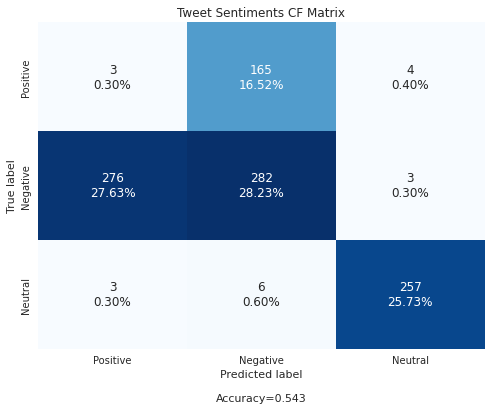

In [66]:
categories = ['Positive','Negative', 'Neutral']
make_confusion_matrix(conf_mat, figsize=(8,6), cbar=False,categories = categories, title='Tweet Sentiments CF Matrix')